In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
import numpy as np
import math

Using TensorFlow backend.
/home/hpc/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def LogQuant(bitwidth, FSR):
    min_ = FSR - (2 ** bitwidth)
    max_ = FSR - 1
    def InnerLogQuant(x):
        x_shape = K.shape(x)
        x_p = K.round(K.log(K.abs(x)))
        x_p = K.clip(x_p, min_, max_)
        x_p = K.map_fn(lambda x: K.switch(x > min_, 2 ** x, 0.0), K.flatten(x_p))
        x_p = K.reshape(x_p, x_shape)
        return K.in_train_phase(x_p, x)
    return InnerLogQuant

def LogQuantOutputShape(input_shape):
    return input_shape

In [5]:
def vgg16_log():
    input_shape = (224, 224, 3)
    fsr = 11
    bitwidth = 4

    model = Sequential([
        Conv2D(64, (3, 3), input_shape=input_shape, padding='same',
               activation='relu'),
        Lambda(LogQuant(bitwidth, fsr+4), output_shape=LogQuantOutputShape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Lambda(LogQuant(bitwidth, fsr+6), output_shape=LogQuantOutputShape),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Lambda(LogQuant(bitwidth, fsr+6), output_shape=LogQuantOutputShape),
        Conv2D(128, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        Conv2D(256, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        Conv2D(256, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+6), output_shape=LogQuantOutputShape),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+5), output_shape=LogQuantOutputShape),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+4), output_shape=LogQuantOutputShape),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+3), output_shape=LogQuantOutputShape),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Lambda(LogQuant(bitwidth, fsr+2), output_shape=LogQuantOutputShape),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Lambda(LogQuant(bitwidth, fsr+1), output_shape=LogQuantOutputShape),
        Dense(4096, activation='relu'),
        Lambda(LogQuant(bitwidth, fsr), output_shape=LogQuantOutputShape),
        Dense(1000, activation='softmax')
    ])

    return model

In [6]:
vgg16_log().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
lambda_15 (Lambda)           (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
lambda_16 (Lambda)           (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
lambda_17 (Lambda)           (None, 112, 112, 128)     0         
__________

In [2]:

# MNISTデータのロード
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 画像1次元配列化
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# 画素を0.0-1.0の範囲に変換
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one-hot-encoding
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


# 多層ニューラルネットワークモデルを構築
model = vgg16_log()

# モデルのサマリを表示
model.summary()

# モデルをコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


# モデルの訓練
history = model.fit(X_train, Y_train,
                    batch_size=100,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)

Using TensorFlow backend.
/home/hpc/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


11493376/11490434 [==============================] - 4s 0us/step


NameError: name 'Lambda' is not defined

In [ ]:
def build_multilayer_perceptron_no_log():
    model = Sequential()

    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    return model

# 多層ニューラルネットワークモデルを構築
model_no_log = build_multilayer_perceptron_no_log()

# モデルのサマリを表示
#model_no_log.summary()

# モデルをコンパイル
model_no_log.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


# モデルの訓練
history_no_log = model_no_log.fit(X_train, Y_train,
                    batch_size=100,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)

In [38]:
import matplotlib.pyplot as plt

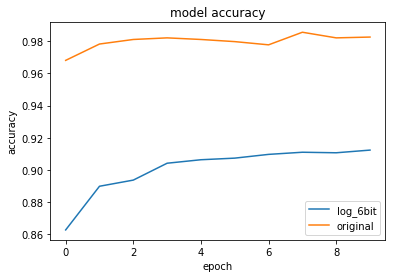

In [40]:
plt.plot(history.history['val_acc'])
plt.plot(history_no_log.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['log_6bit', 'original'], loc='lower right')
plt.show()

In [3]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras import optimizers
import numpy as np
import sys
from PIL import Image
import pickle
from io import BytesIO
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
def log_layer():
    fsr = 11
    bitwidth = 4
    LogQuants = [
        Lambda(LogQuant(bitwidth, fsr+4), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+6), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+6), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+7), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+6), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+5), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+4), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+3), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+2), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr+1), output_shape=LogQuantOutputShape),
        Lambda(LogQuant(bitwidth, fsr), output_shape=LogQuantOutputShape),
    ]

    return LogQuants

In [5]:
input_tensor = Input(shape=(224, 224, 3))
vgg16 = VGG16(include_top=True, weights='imagenet', input_tensor=input_tensor)

model = Sequential()
log = log_layer()
cnt = 0
# 最後のconv層の直前までの層をfreeze
for layer in vgg16.layers:
    model.add(layer)
    if type(layer)==Conv2D or type(layer)==Dense:
        if cnt < len(log):
            model.add(log[cnt])
            cnt += 1
        
# Fine-tuningのときはSGDの方がよい
#model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#              metrics=['accuracy'])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
lambda_2 (Lambda)            (None, 224, 224, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
__________

In [7]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [34]:
img_path = '/home/hpc/imagenet/test/ILSVRC2012_test_00000001.JPEG'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)
results = decode_predictions(features, top=5)[0]
for result in results:
    print(result)

40960/35363 [==================================] - 0s 7us/step
('n01930112', 'nematode', 0.74258345)
('n04447861', 'toilet_seat', 0.033605784)
('n03532672', 'hook', 0.026808316)
('n04286575', 'spotlight', 0.015860554)
('n04553703', 'washbasin', 0.013329401)


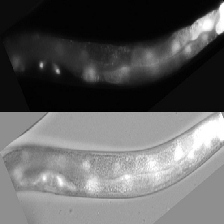

In [38]:
img

In [8]:
import pickle

In [9]:
with open('/home/hpc/imagenet/train/image_path.pkl', 'rb') as f:
    image_paths = pickle.load(f)

In [10]:
def predict(img_path, model_):
    ans = img_path[:9]
    img = image.load_img('/home/hpc/imagenet/train/'+ans+'/'+img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model_.predict(x)
    results = decode_predictions(features, top=5)[0]
    for result in results:
        if result[0] == ans:
            return True
    return False

In [11]:
from tqdm import tqdm

In [12]:
cnt = 0
for path in tqdm(image_paths[:10]):
    if predict(path, vgg16):
        cnt += 1
print (cnt/10)

100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

1.0


In [13]:
cnt = 0
for path in tqdm(image_paths[:1000]):
    if predict(path, vgg16):
        cnt += 1
print (cnt/1000)

100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]

0.91


In [ ]:
cnt = 0
for path in tqdm(image_paths[:1000]):
    if predict(path, model):
        cnt += 1
print (cnt/1000)

100%|██████████| 1000/1000 [25:55:33<00:00, 93.33s/it] 

0.91
